### Neural Network for Regression

The structure and operations of a neural network for regression are basically the same to those used for classification, with three key differences:

1. **No Sigmoid at the Output Layer:**  
   In regression tasks, the output layer does not apply a sigmoid activation function. Instead, the raw output of the network represents the predicted values.

2. **Mean Squared Error (MSE) as the Cost Function:**  
   The loss function for regression is the Mean Squared Error (MSE), defined as:

   $$
   J(\Theta, B) = \frac{1}{2m} \sum_{i=1}^m \left( h(x^{(i)}) - y^{(i)} \right)^2 + \frac{\lambda}{2m} \sum_{l=1}^{L-1} \sum_{v=1}^{d_{l-1}} \sum_{j=1}^{s_l} \left( \Theta_{jv}^{[l]} \right)^2
   $$
      Here we consider its L2 regularized version where $\lambda$ is the regularization parameter.

3. **Error Calculation at the Output Layer:**  
   In regression, the error for the output layer ($L$) is computed as the simple difference between the predicted output and the actual value:

   $$
   \delta^{[L]} = A^{[L]} - y
   $$

Therefore, to adapt the neural network code for regression, you only need to make the above modifications.


In [39]:
import numpy as np
import pandas as pd

from scratch_libraries.regression_nn import NeuralNetwork

In [40]:
house= pd.read_csv('./datasets/houses.csv')

In [41]:
house = house.sample(frac=1, random_state=123).reset_index(drop=True)

In [42]:
x = house[['GrLivArea','LotArea','GarageArea','FullBath']].values

y = house['SalePrice'].values
y = y.reshape(-1, 1) # reshape (for explicit dimensions)

train_index = round(len(x)*0.8)

X_train = x[:train_index]
y_train = y[:train_index]

X_test = x[train_index:]
y_test = y[train_index:]

In [43]:
mean= X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [44]:
print(X_train)

[[ 1.02818732 -0.09200321 -0.19555998  0.79815675]
 [ 0.51560443 -0.08293953  1.43101858  0.79815675]
 [ 0.38598577 -0.6779945  -0.45015489  0.79815675]
 ...
 [ 0.62165606  0.11684324  1.40744497  0.79815675]
 [-0.70595325  0.34753795  0.04017604 -1.01908903]
 [ 0.21316089  0.23171356  2.0580764   0.79815675]]


In [45]:
nn = NeuralNetwork(layers=[X_train.shape[1], 10, 10, 1], epochs=3000, alpha=1e-3, lmd=0.1)
nn.fit(X_train, y_train)

In [46]:
preds = nn.predict(X_test)
print(preds[:20])

[[180980.48653479]
 [180980.48653479]
 [180980.48653256]
 [180980.48653278]
 [180980.48653479]
 [180980.48653479]
 [180980.48653256]
 [180980.48653256]
 [180980.48653479]
 [180980.48653256]
 [180980.48653256]
 [180980.48653479]
 [180980.48653256]
 [180980.48653479]
 [180980.48653421]
 [180980.48653371]
 [180980.48653255]
 [180980.48653256]
 [180980.48653479]
 [180980.48653263]]


In [47]:
print(preds.shape)

(292, 1)


In [48]:
print(y_test.shape)

(292, 1)


In [49]:
print(nn.compute_performance(preds, y_test))

{'mae': 59749.61321095011, 'mape': 37.98428436110986, 'mpe': 18.60359421393778, 'mse': 6388734047.851775, 'rmse': 79929.55678503275, 'r2': -1.4392476310742808e-05}


If we look at the results we got we can see that the model seems stuck producing the same prediction repeatedly. In fact, examining the predictions, we observe an array where all values are identical. This issue is not due to an implementation bug in the Neural Network Regression. It is neither due to bad hyperparameters choose (changing hyperparameters you gen a little better metrics performance, but you will not solve this problem).

In fact, this problem arises due to a deeper iussue related to the **magnitude of the target variable values (house prices).**  House prices, often ranging in tens or hundreds of thousands, introduce challenges due to their large magnitude:  

1. **Numerical Instability:**  
   Neural networks update weights incrementally based on the loss gradient. If the target variable has a large magnitude, the loss values and gradients will also be large, leading to small, slow updates to the weights. Consequently, the model converges very slowly or gets stuck, unable to capture meaningful patterns in the data.  

2. **Loss Function Effect:**  
   The learning process in neural networks depends on efficiently minimizing the loss function. The loss function we adopted, the **Mean Squared Error (MSE)**, amplifies the impact of large target values. These values dominate the error, skewing the learning process and making the model ineffective at predicting accurately smaller values.  

-> I suppose that the model likely got trapped in a local minimum dominated by a large target value. So that optimizing the loss for such large value overwhelmed the learning process, preventing effective training.  

In such cases to solve the problem what we could do is normalize also the target variable (e.g., through a Z-score normalization). Specifically, what we want to do is:  

- **Normalize the Target:**  
      Apply Z-score normalization to the training target variable:  
      y_train_normalized = (y_train - y_train.mean()) / y_train.std()

- **Train the Model:**
      Fit the neural network using the normalized target values.
  
- **Re-denormalize Predictions:**
      Transform predictions back to the original scale for interpretation:
      y_pred_original = y_pred_normalized * y_train.std() + y_train.mean()


**Why Target Normalization Works?**

By rescaling the target to a smaller range, the model can learn more effectively. In fact, with normalized targets, the magnitude of the loss function and its gradients are reduced, ensuring that weight updates occur at a reasonable scale. So, the optimization algorithm can efficiently minimize the loss function without being overwhelmed by large gradients (and as a consequence, this prevents the model from getting stuck in local minima).  

**Choosing the Right Normalization Technique**  
In this case, **Z-score normalization** is the appropriate choice: 
- We don’t choose **Min-Max Normalization** because, as we studied, it relies on the range of the training data. However, in our case, house prices can vary widely without clear bounds.  
- If test data includes values outside this range, predictions may become invalid. Z-score normalization, on the other hand, is robust to such variations.  
- A **Min-Max Normalization** can make more sense, for example, when making regression on images since pixel values in images are bounded between 0 and 255.

In [50]:
## NORMALIZATION

print('Before: ', y_train)

# Normalize the Target
mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
print('After normalization: ', y_train)

Before:  [[222500]
 [ 87000]
 [130000]
 ...
 [314813]
 [180500]
 [315500]]
After normalization:  [[ 0.52364475]
 [-1.18535309]
 [-0.64301429]
 ...
 [ 1.68794525]
 [-0.00608152]
 [ 1.69661006]]


In [51]:
nn = NeuralNetwork(layers=[X_train.shape[1], 10, 10, 1], epochs=3000, alpha=1e-3, lmd=0.1)
# Fit the model with nomalized target
nn.fit(X_train, y_train)

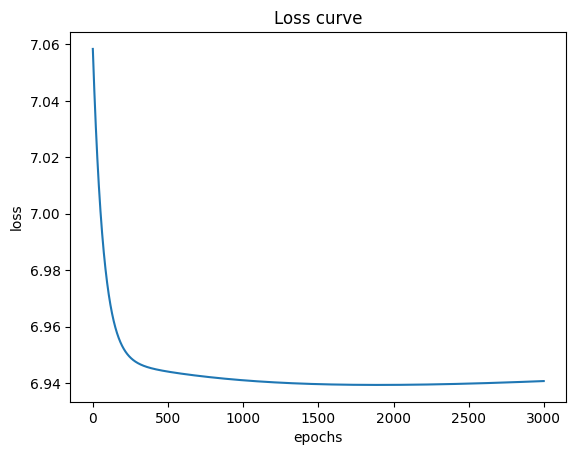

In [52]:
nn.plot_loss()

In [53]:
preds = nn.predict(X_test)
print(preds[:20])

[[-0.81591386]
 [-0.42823451]
 [ 0.58901138]
 [ 0.25699158]
 [-0.64857698]
 [-0.72788788]
 [ 1.18309014]
 [ 1.00745804]
 [-0.93232265]
 [ 1.08907211]
 [ 1.19103496]
 [-0.74999713]
 [ 0.9804439 ]
 [-0.74113701]
 [ 0.10244798]
 [ 0.13832827]
 [ 0.73532634]
 [ 0.48232334]
 [-0.59371676]
 [ 0.44116312]]


In [54]:
# Re-denormalize predictions
preds = preds * std_y + mean_y

In [55]:
print(preds[:20])

[[116291.44454596]
 [147029.07963969]
 [227682.67397769]
 [201358.07470345]
 [129558.95557568]
 [123270.69350963]
 [274784.93980643]
 [260859.73246831]
 [107061.83091319]
 [267330.60513743]
 [275414.85464279]
 [121517.73430515]
 [258717.88303363]
 [122220.21930375]
 [189104.89522317]
 [191949.70805828]
 [239283.43552182]
 [219223.78068458]
 [133908.61559946]
 [215960.34243455]]


In [56]:
# Just to compare our preds with the real target values
print(y_test[:20])

[[113000]
 [110000]
 [235000]
 [150000]
 [140000]
 [132500]
 [465000]
 [380000]
 [ 91500]
 [290000]
 [256300]
 [ 79500]
 [325000]
 [145000]
 [220000]
 [181500]
 [235000]
 [262280]
 [144500]
 [145000]]


In [57]:
print(nn.compute_performance(preds, y_test))

{'mae': 35785.142639278165, 'mape': 21.00856294563624, 'mpe': 8.185521511877663, 'mse': 2731981785.3305264, 'rmse': 52268.36313995806, 'r2': 0.5723689411938659}


By applying the target normalization approach, we can now see that the model is demonstrating significant improvements in both prediction diversity and performance metrics:
- The predictions now vary meaningfully, indicating that the network is capturing patterns in the data instead of being stuck in uniform outputs.
- Moreover, keeping the same structure and the same hyperparameters for our network, we can see that performance metrics such as MAE, MAPE and R² highlight a better reduction in prediction errors and an enhanced fit to the data compared to the earlier results.

Note: Doing an approapriate Grid Search we could get even better results.